In [1]:
import importlib
import Energy_node as eNode
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("default")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['figure.facecolor'] = 'white'
importlib.reload(eNode)
colors = ( "blue", "green", "red","orange", "indigo", "beige")

In [6]:
########################################################"
# 
#           TO CHANGE
# 
# ########################################################"

#BME680 + Apollo3 + SX1276 + AEM10491 + EDLC supercap + PV cell
#MCU : Apollo3
    #6 µA/MHz executing from FLASH or RAM at 3.3 V
    #1 µA deep sleep mode (BLE in shutdown) with RTC at 3.3 V
##################
#BME680 + Apollo3 + SX1276 + AEM10491 + EDLC supercap + PV cell
#MCU : Apollo3
    #6 µA/MHz executing from FLASH or RAM at 3.3 V
    #1 µA deep sleep mode (BLE in shutdown) with RTC at 3.3 V
MCU_activCur  = 0.570
MCU_sleepCur  = 0.0032
MCU_voltage   = 3.3

#Transceiver : sleep current general : 0.2 uA
radio_sleepCur = 0.0002
radio_voltage  = 3.3
    #Tx : LoRa : low Tx current: 30 mA *3.3V  = 99.9 mW
TX_activCur  = 58 
TX_duration  = 0.33    #50 bytes in SF10 : 1.32s
    #Rx : LoRa : low Tx current: 11 mA *3.3V  = 33.3 mW
RX_activCur  = 11
RX_duration= TX_duration

#BME680 no AI: AVERAGE POWER
bme_sleepCur = 0.00015
bme_voltage  = 3.3
    #Humidty + temperature + Pressure:
        # 1Hz : 3.7uA *3.3V = 0.012 mW
TPH_activCur  = 0.45
TPH_duration  = 50e-3
    # + Gas scan
        # 0.09-12 mA  *3.3V = 0.297-  39.6mW
TPHG_activCur  = 12
TPHG_duration  = 500e-3


In [7]:
radio_module = eNode.Node_module(name="LoRa radio",
                            v=radio_voltage,
                            i_sleep=radio_sleepCur)
radio_state_TX = eNode.Module_state("TX",i = TX_activCur,duration = None)
radio_state_RX = eNode.Module_state("RX",i = RX_activCur,duration = None)
radio_module.add_state(radio_state_TX)
radio_module.add_state(radio_state_RX)

bme_module   = eNode.Node_module(name="BME680",
                            v=bme_voltage,
                            i_sleep=bme_sleepCur)
bme_state_TPH  = eNode.Module_state("TPH", i = TPH_activCur,duration = TPH_duration)
bme_state_TPHG = eNode.Module_state("TPHG",i = TPHG_activCur,duration = TPHG_duration)
bme_module.add_state(bme_state_TPH)
bme_module.add_state(bme_state_TPHG)

apollo_module = eNode.Node_module(name="Apollo3",
                            v=MCU_voltage,
                            i_sleep=MCU_sleepCur)
apollo_state_active  = eNode.Module_state("Active",i = MCU_activCur,duration = None)
apollo_module.add_state(apollo_state_active)

module_List = [apollo_module,radio_module,bme_module]

In [8]:
task_send = eNode.Node_task(  name = "Send Message", 
                        node_modules= module_List, 
                        moduleUsed = [  apollo_module,
                                        radio_module], 
                        subtasks   = [  eNode.Node_subtask(name='Proc',module=apollo_module,
                                        moduleState=apollo_state_active, stateDuration=100e-3),
                                        eNode.Node_subtask(name='TX'  ,module=radio_module ,
                                        moduleState=radio_state_TX     , stateDuration=TX_duration)], 
                        taskDuration = 500e-3, 
                        task_rate =24)
    

task_rxtx = eNode.Node_task(  name = "RXTX Message", 
                        node_modules= module_List, 
                        moduleUsed = [  apollo_module,
                                        radio_module], 
                        subtasks   = [  eNode.Node_subtask(name='Proc',module=apollo_module,
                                        moduleState=apollo_state_active, stateDuration=100e-3),
                                        eNode.Node_subtask(name='TX'  ,module=radio_module ,
                                        moduleState=radio_state_TX     , stateDuration=TX_duration),
                                        eNode.Node_subtask(name='RX'  ,module=radio_module ,
                                        moduleState=radio_state_RX     , stateDuration=RX_duration)], 
                        taskDuration = 1000e-3, 
                        task_rate =24)

task_TPH = eNode.Node_task(   name = "TPH meas.", 
                        node_modules= module_List, 
                        moduleUsed = [  apollo_module,
                                        bme_module], 
                        subtasks   = [  eNode.Node_subtask(name='Proc',module=apollo_module,
                                        moduleState=apollo_state_active, stateDuration=100e-3),
                                        eNode.Node_subtask(name='TPH' ,module=bme_module ,
                                        moduleState=bme_state_TPH     , stateDuration=TPH_duration)], 
                        taskDuration = 100e-3, 
                        task_rate =24*10)

task_TPHG = eNode.Node_task(  name = "TPHG meas.", 
                        node_modules= module_List, 
                        moduleUsed = [  apollo_module,
                                        bme_module], 
                        subtasks   = [  eNode.Node_subtask(name='Proc',module=apollo_module,
                                        moduleState=apollo_state_active, stateDuration=100e-3),
                                        eNode.Node_subtask(name='TPHG' ,module=bme_module ,
                                        moduleState=bme_state_TPHG     , stateDuration=TPHG_duration)], 
                        taskDuration = 550e-3, 
                        task_rate =24*3)

-------------------------------------------------
            Tasks summary (1 Day)            
-------------------------------------------------
Task name            : Sleep          RXTX Message   TPHG meas.     
Times/day    [1/d]   : 1              24             72             
Tot. durat.  [s]     : 86336.4000     24.0000        39.6000        
Tot. en./d   [mJ]    : 1011.4309      1808.1438      1439.5133      
Node en./d   [mJ]    : 4259.0879       
Average pow. [mW]    : 0.0493          
-------------------------------------------------
-------------------------------------------------
          Module summary (1 Day)             
-------------------------------------------------
Module       State        Active [s]   Energy [mJ]  
Apollo3                   9.6000       930.3402     
     -       Sleep        86390.4000   912.2826     
     -       Active       9.6000       18.0576      
LoRa radio                15.8400      1860.3975    
     -       Sleep        86384.1600 

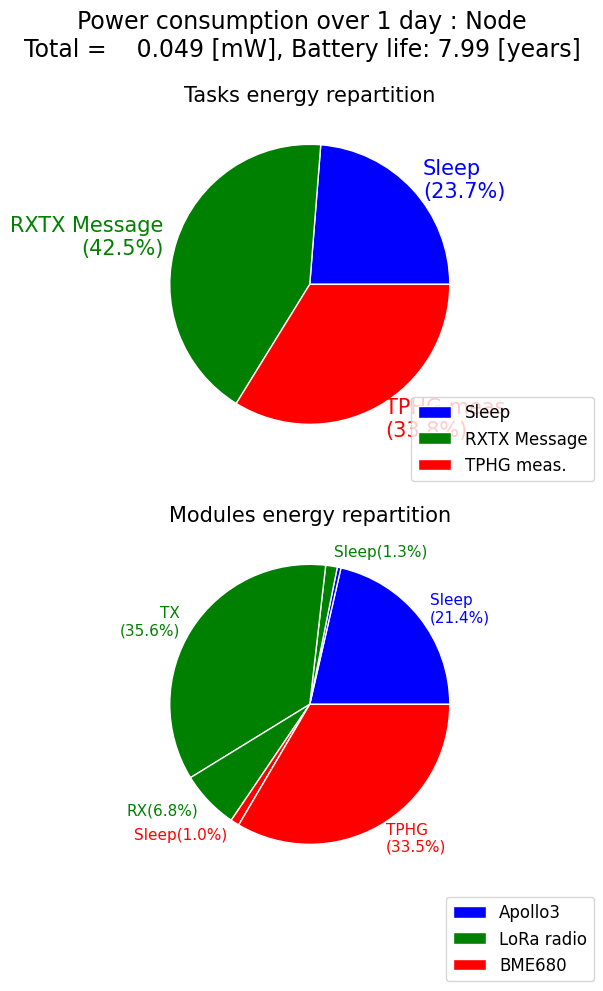

In [10]:

node = eNode.Node_profile("Node", module_List,AAAbattery=2)
node.add_task(task_rxtx)
task_rxtx.taskRate = 1
node.add_task(task_TPHG)
task_TPHG.taskRate = 24*10
node.recompute()
node.print_Tasks()
node.print_Modules()
node.plot_Power()


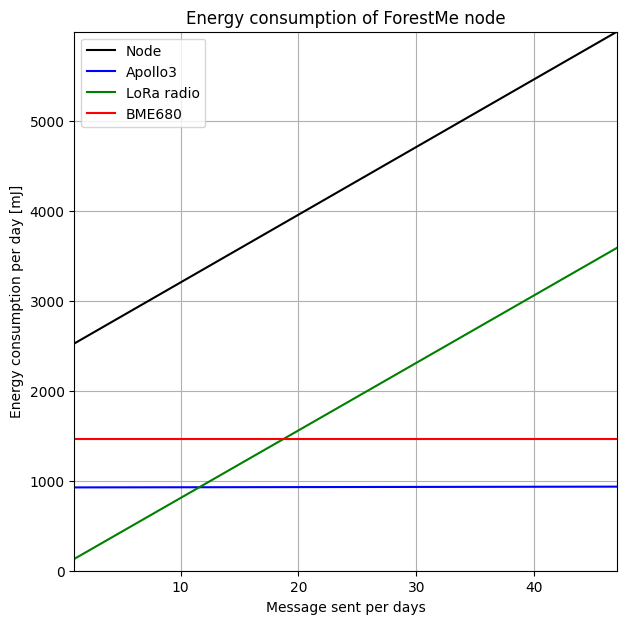

In [12]:
# Sensitivity analysis for environmental monitoring : Data sent each time it is captured
# msg_per_day : data capture rate/day
# 2 AAA batteries : 3.3V is assumed and 1150mAh
msg_per_day = np.arange(start = 1, stop = 48, step = 1)
msg_param = msg_per_day

results = np.zeros(np.shape(msg_param))
results_per_task = np.zeros((len(node.task_list),len(msg_param)))
results_per_module = np.zeros((len(node.module_list),len(msg_param)))

node = eNode.Node_profile("Node", module_List,AAAbattery=2)
node.add_task(task_rxtx)
task_rxtx.taskRate = 1
node.add_task(task_TPHG)
task_TPHG.taskRate = 12*24

for (i,param) in enumerate(msg_param):
    task_rxtx.task_rate = param
    node.recompute()
    results[i]= node.energy_day
    for (j,task) in enumerate(node.task_list):
        results_per_task[j,i] = task.energy_day
    for (j,module) in enumerate(node.module_list):
        results_per_module[j,i] = module.energy_day    

fig = plt.figure(figsize=(7,7))
ax = plt.subplot(111)
plt.plot(msg_param,results,label = 'Node',color ='black')
for (j,module) in enumerate(node.module_list):
    plt.plot(msg_param,results_per_module[j,:],label = module.name,color=colors[j]) 
plt.title('Energy consumption of ForestMe node')
ax.set_ylim([0,np.max(results)])
ax.set_xlim([np.min(msg_param),np.max(msg_param)])
ax.set_xlabel("Message sent per days")
ax.set_ylabel("Energy consumption per day [mJ]")
ax.legend(loc='upper left')
ax.grid()
plt.show()
